In [2]:
from eurostat_dataset import eurostat_dataset # packed in class the method to wrangle eurostat's table 
import pandas as pd
import sqlite3
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# to activate env: venv\Scripts\activate.bat
# python -m pip freeze > requirements.txt




1. Wrangling the data from the Eurostat database.

In [3]:
# uncheck this comment to download dataset to the local sqlite database in the same folder
# eurostat_dataset(code='NRG_BAL_S').WriteToDatabase() #it takes about 8 min downloading
# eurostat_dataset(code='NRG_INF_EPCRW').WriteToDatabase()
# write to a local sqlite database, so you don't need to wait everytime when you restart the kernel or the file

In [45]:
full_balance = eurostat_dataset(code='NRG_BAL_C').GetDf()

MemoryError: Unable to allocate 36.9 MiB for an array with shape (38664000,) and data type bool

In [36]:
def db_tables():
    """
    Check the tables that has been written to the local database
    Args:
        None
    Returns:
        The list of tables titles in the local sqlite database
    
    """
    con = sqlite3.connect('ngr.db')
    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    print(cursor.fetchall())
    con.close

In [37]:
def read_df_from_db(table):
    """
    Reading the table from db to DataFrame
    Args:
        table(str): The title of one table we get from the list db_tables()
    Returns:
        Dataframe
    
    """
    con = sqlite3.connect('ngr.db')
    cursor = con.cursor()   
    df = pd.read_sql_query("SELECT * FROM "+ table , con)
    con.close
    df.drop(columns=['index'],inplace=True)

    return df

In [38]:
tables = db_tables()
print(f'The list of tables in the local sqlite database {tables}') # we can see the title of tables in the database 'ngr.db'

[('nrg_bal_s',), ('nrg_inf_epcrw',), ('electricity_eurostat',), ('nrg_bal_sd',)]
The list of tables in the local sqlite database None


1.1. Getting the dataset info: title, start and end date of the data.

In [39]:
#Use the method DatasetInfo() from eurostat_dataset to get the metadata
renew = eurostat_dataset(code='nrg_inf_epcrw').DatasetInfo()
dataset_info=eurostat_dataset(code='NRG_BAL_S').DatasetInfo()
sankey = eurostat_dataset(code='NRG_BAL_SD').DatasetInfo()
print(f'The first dataset: "{dataset_info[0]}" dates from {dataset_info[1]} to {dataset_info[2]}.')
print(f'The second dataset: "{renew[0]}" dates from {renew[1]} to {renew[2]}.')
sankey

The first dataset: "Simplified energy balances" dates from 1990 to 2021.
The second dataset: "Electricity production capacities for renewables and wastes" dates from 1990 to 2021.


1.2. Final energy consumption by European countries.

In [8]:
#reading the tables from the local database
bal = read_df_from_db('nrg_bal_s')
get_energy = read_df_from_db('nrg_inf_epcrw')


In [40]:
sankey = read_df_from_db("nrg_bal_sd")

In [42]:
sankey.to_csv('sankey.csv')

In [34]:
energy_bakance = eurostat_dataset.GetDf("nrg_bal_sd")

AttributeError: 'str' object has no attribute 'code'

In [9]:
def preprocess_dataset(df):
    """
    Preprocess dataframe

    Args:
        Dataframe of Eurostat dataset that contains value and date columns
        
    Returns:
        Dataframe preprocessed for the futher manipulation
    
    """
    df.value=df.value.astype('str').fillna('').str.extract(r"(\d+)|(\d+)\.")[0].astype('Int32')
    df.date=pd.to_numeric(df.date)
    return df

In [10]:
bal = preprocess_dataset(bal)
get_energy = preprocess_dataset(get_energy)

In [11]:
get_energy

,siec,plant_tec,unit,geo,date,value
0,Solid biofuels,Net maximum electrical capacity,Megawatt,Albania,2021,0
1,Solid biofuels,Net maximum electrical capacity,Megawatt,Austria,2021,764
2,Solid biofuels,Net maximum electrical capacity,Megawatt,Bosnia and Herzegovina,2021,9
3,Solid biofuels,Net maximum electrical capacity,Megawatt,Belgium,2021,448
4,Solid biofuels,Net maximum electrical capacity,Megawatt,Bulgaria,2021,13
...,...,...,...,...,...,...
34395,Municipal waste,Net maximum electrical capacity,Megawatt,Slovakia,1990,0
34396,Municipal waste,Net maximum electrical capacity,Megawatt,Türkiye,1990,0
34397,Municipal waste,Net maximum electrical capacity,Megawatt,Ukraine,1990,0
34398,Municipal waste,Net maximum electrical capacity,Megawatt,United Kingdom,1990,31


In [12]:
balance=bal.copy() #without slicing
balance = balance.query('unit=="Gigawatt-hour" and siec=="Total" and nrg_bal=="Final consumption - energy use" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

Final consumption - energy use (Gigawatt-hour)

In [13]:
balance.head()

,nrg_bal,siec,unit,geo,date,value
5649,Final consumption - energy use,Total,Gigawatt-hour,Albania,2021,23405
5650,Final consumption - energy use,Total,Gigawatt-hour,Austria,2021,306992
5651,Final consumption - energy use,Total,Gigawatt-hour,Bosnia and Herzegovina,2021,50070
5652,Final consumption - energy use,Total,Gigawatt-hour,Belgium,2021,385902
5653,Final consumption - energy use,Total,Gigawatt-hour,Bulgaria,2021,117930


Population

In [14]:
#get population dataset and clean it
pop = eurostat_dataset('TPS00001').GetDf()
population=preprocess_dataset(pop)

In [15]:
#merge with balance tables to have the measure per capita
m_balance = balance.merge(population[["geo","date","value"]],on=['geo',"date"],suffixes=("", "_population"))
m_balance = m_balance.assign(per_capita=lambda x: x.value*1000/x.value_population)

In [16]:
"Gross electricity production"
el_production = bal.query('unit=="Gigawatt-hour" and siec=="Total" and nrg_bal=="Gross electricity production" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')



In [17]:
renewables = bal.query('unit=="Gigawatt-hour" and siec=="Renewables and biofuels" and nrg_bal=="Gross electricity production" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

In [46]:
el_consumption = bal.query('unit=="Gigawatt-hour" and siec=="Electricity" and nrg_bal=="Final consumption - energy use" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

2. Energy Consumption, electricity production and electricity production from renewable

 ###### As for Latvia in 2020: 
 ###### - Energy consumption: 44172.893 Gigawatt-hour
 ###### - electricity production - 5724.846 Gigawatt-hour. 13% from Energy consumption
 ###### - electricity production from renewable - 3649.529 Gigawatt-hour. 63% from electricity production
 ###### - 87% electricity production from the Hydro 


In [18]:
def measure_series(df,measure):
    """
    One pandas series for the one measure

    Args:
        Dataframe: Preprocessed Dataframe of Eurostat dataset
        measure (str): the title of measure
        
        
    Returns:
        Named pandas series with the indexes: geo, date for the further concat
    
    """
    return df[['geo','date','value']].rename(columns={'value':measure}).set_index(['geo','date']).squeeze()

In [19]:
#the query to get only aggragated renewables sources from the second table "Electricity production capacities for renewables and wastes"
ren_table = get_energy.query('siec in ("Solid biofuels","Biogases","Hydro","Geothermal","Wind","Solar") \
    and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

#calculation of relative measures: percentage of the each renewable source from the sum of production
ren_table['perc'] = ren_table['value'] / ren_table.groupby(['geo','date'])['value'].transform('sum')
ren_table['max_perc'] = ren_table.groupby(['geo','date'])['perc'].transform(max)
source_nameSeries = ren_table.query('perc==max_perc')[['geo','date','siec']].drop_duplicates(subset=['geo','date'])\
                        .rename(columns={'siec':'Main Renewable Source'}).set_index(['geo','date']).squeeze()

source_percSeries = ren_table.query('perc==max_perc')[['geo','date','perc']].drop_duplicates(subset=['geo','date'])\
                        .rename(columns={'perc':'Main Renewable Source,perc'}).set_index(['geo','date']).squeeze()


In [47]:
consumptionSeries = measure_series(balance,'Final consumption')
productionSeries = measure_series(el_production,'Electricity production')
renewSeries = measure_series(renewables,'Electricity production from Renewables and biofuels')
elconsumptionSeries = measure_series(el_consumption,'Electricity consumption')


In [61]:
#concat the all pandas series,the result - the table with all measures. Non-relative measures in Gigawatt-hour
concated = pd.concat([consumptionSeries,productionSeries,renewSeries,elconsumptionSeries,source_nameSeries,source_percSeries],axis=1)
concated['Electricity production from Renewables and biofuels'] = pd.to_numeric(concated['Electricity production from Renewables and biofuels'])
concated["Electricity production from Final consumption,perc"] = concated['Electricity production']/concated['Final consumption']
concated["Electricity production from Renewables and biofuels,perc"] = concated['Electricity production from Renewables and biofuels']/concated['Electricity production'] 
concated["Ratio of renewable production to electricity consumption,perc"] = concated['Electricity production from Renewables and biofuels']/concated['Electricity consumption'] 


In [68]:
concated[concated.geo=='Iceland']

,geo,date,Final consumption,Electricity production,Electricity production from Renewables and biofuels,Electricity consumption,Main Renewable Source,"Electricity production from Renewables and biofuels,perc","Ratio of renewable production to electricity consumption,perc","Main Renewable Source,perc","Electricity production from Final consumption,perc"
18,Iceland,2021,34708,19614,19611,18345,Hydro,0.999847,1.069011,0.736329,0.565115
58,Iceland,2020,33375,19127,19124,17868,Hydro,0.999843,1.070293,0.736329,0.573094
98,Iceland,2019,34128,19488,19486,18226,Hydro,0.999897,1.069132,0.735407,0.571027
138,Iceland,2018,35807,19829,19827,18487,Hydro,0.999899,1.072483,0.734851,0.553774
178,Iceland,2017,33133,19238,19236,17891,Hydro,0.999896,1.075177,0.737153,0.58063
218,Iceland,2016,32579,18549,18546,17303,Hydro,0.999838,1.071837,0.748399,0.569354
258,Iceland,2015,33129,18798,18794,17470,Hydro,0.999787,1.075787,0.748399,0.567418
298,Iceland,2014,31862,18122,18119,16830,Hydro,0.999834,1.076589,0.748115,0.568765
338,Iceland,2013,31479,18115,18110,16823,Hydro,0.999724,1.076502,0.748397,0.575463
378,Iceland,2012,30243,17549,17546,16357,Hydro,0.999829,1.072691,0.738395,0.580267


In [63]:



cols = concated.columns.to_list()
new_cols = cols[:5]+cols[7:9]+cols[5:7]
concated = concated[new_cols].reset_index()

In [54]:
conn = sqlite3.connect("ngr.db")
concated.to_sql("electricity_eurostat", conn, if_exists="replace")
conn.close()

In [24]:
concated.to_csv("electricity_eurostat.csv")
bal.to_csv("energy_balance.csv")
pop.to_csv("population.csv")

Plots

In [64]:
df_plot = concated[concated.date==2020].dropna()

In [56]:
df_plot.loc[df_plot.geo=='Kosovo (under United Nations Security Council Resolution 1244/99)','geo'] = 'Kosovo'
df_plot.loc[df_plot.geo=='Germany (until 1990 former territory of the FRG)','geo'] = 'Germany'

Text(0.5, 0.98, 'Final consumption,Electricity production and Electricity production from Renewables and biofuels, Gigawatt-hour')

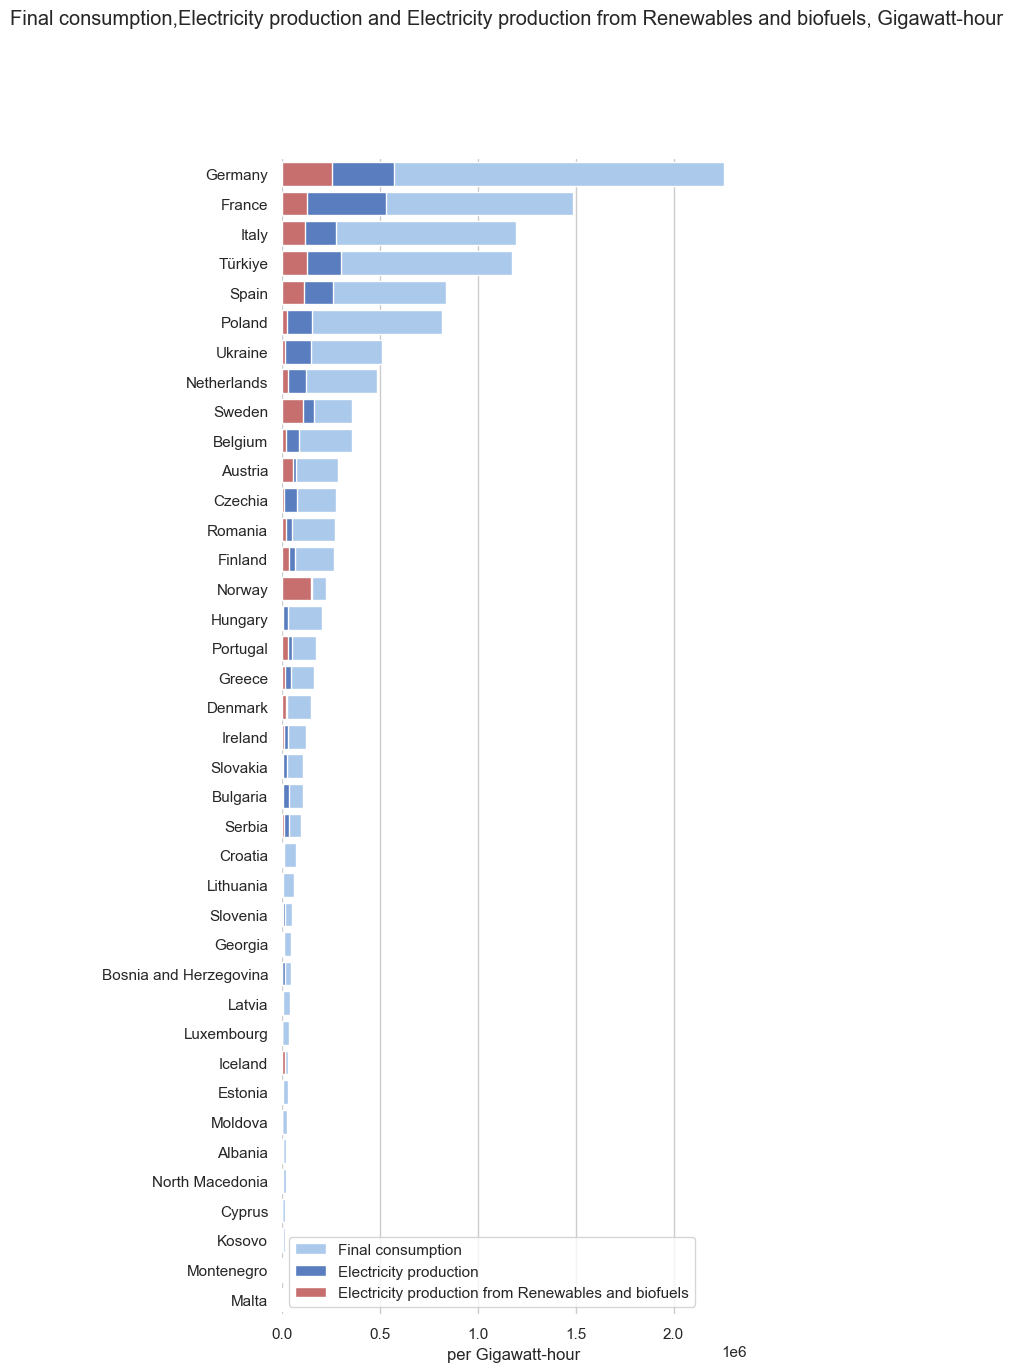

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
consumption = df_plot.sort_values("Final consumption", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Final consumption", y="geo", data=consumption,
            label="Final consumption", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Electricity production", y="geo", data=consumption,
            label="Electricity production", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Electricity production from Renewables and biofuels", y="geo", data=consumption,
            label="Electricity production from Renewables and biofuels", color="r")

# Add a legend and informative axis label
ax.legend(ncol=1,  frameon=True)
ax.set( ylabel="",
       xlabel="per Gigawatt-hour")
sns.despine(left=True, bottom=True)

f.suptitle("Final consumption,Electricity production and Electricity production from Renewables and biofuels, Gigawatt-hour")


In [71]:
def plot_measure(df_plot2,measure):
    sns.set_theme(style="dark")

    df_plot2 = df_plot2.dropna()
    df_plot2.loc[df_plot2.geo=='Kosovo (under United Nations Security Council Resolution 1244/99)','geo'] = 'Kosovo'
    df_plot2.loc[df_plot2.geo=='Germany (until 1990 former territory of the FRG)','geo'] = 'Germany'

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=df_plot2,
        x="date", y=measure, col="geo", #hue="date",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap=4, height=2, aspect=1.5, legend=False
    )

    # Iterate over each subplot to customize further
    for geo, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.8, .85, geo, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=df_plot2, x="date", y=measure, units="geo",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )

    # Reduce the frequency of the x axis ticks
    # ax.set_xticks(ax.get_xticks()[::2])

    # Tweak the supporting aspects of the plot
    g.set_titles(" ")
    g.set_axis_labels("", "")
    # g.tight_layout()
    g.figure.suptitle(measure)
    return g



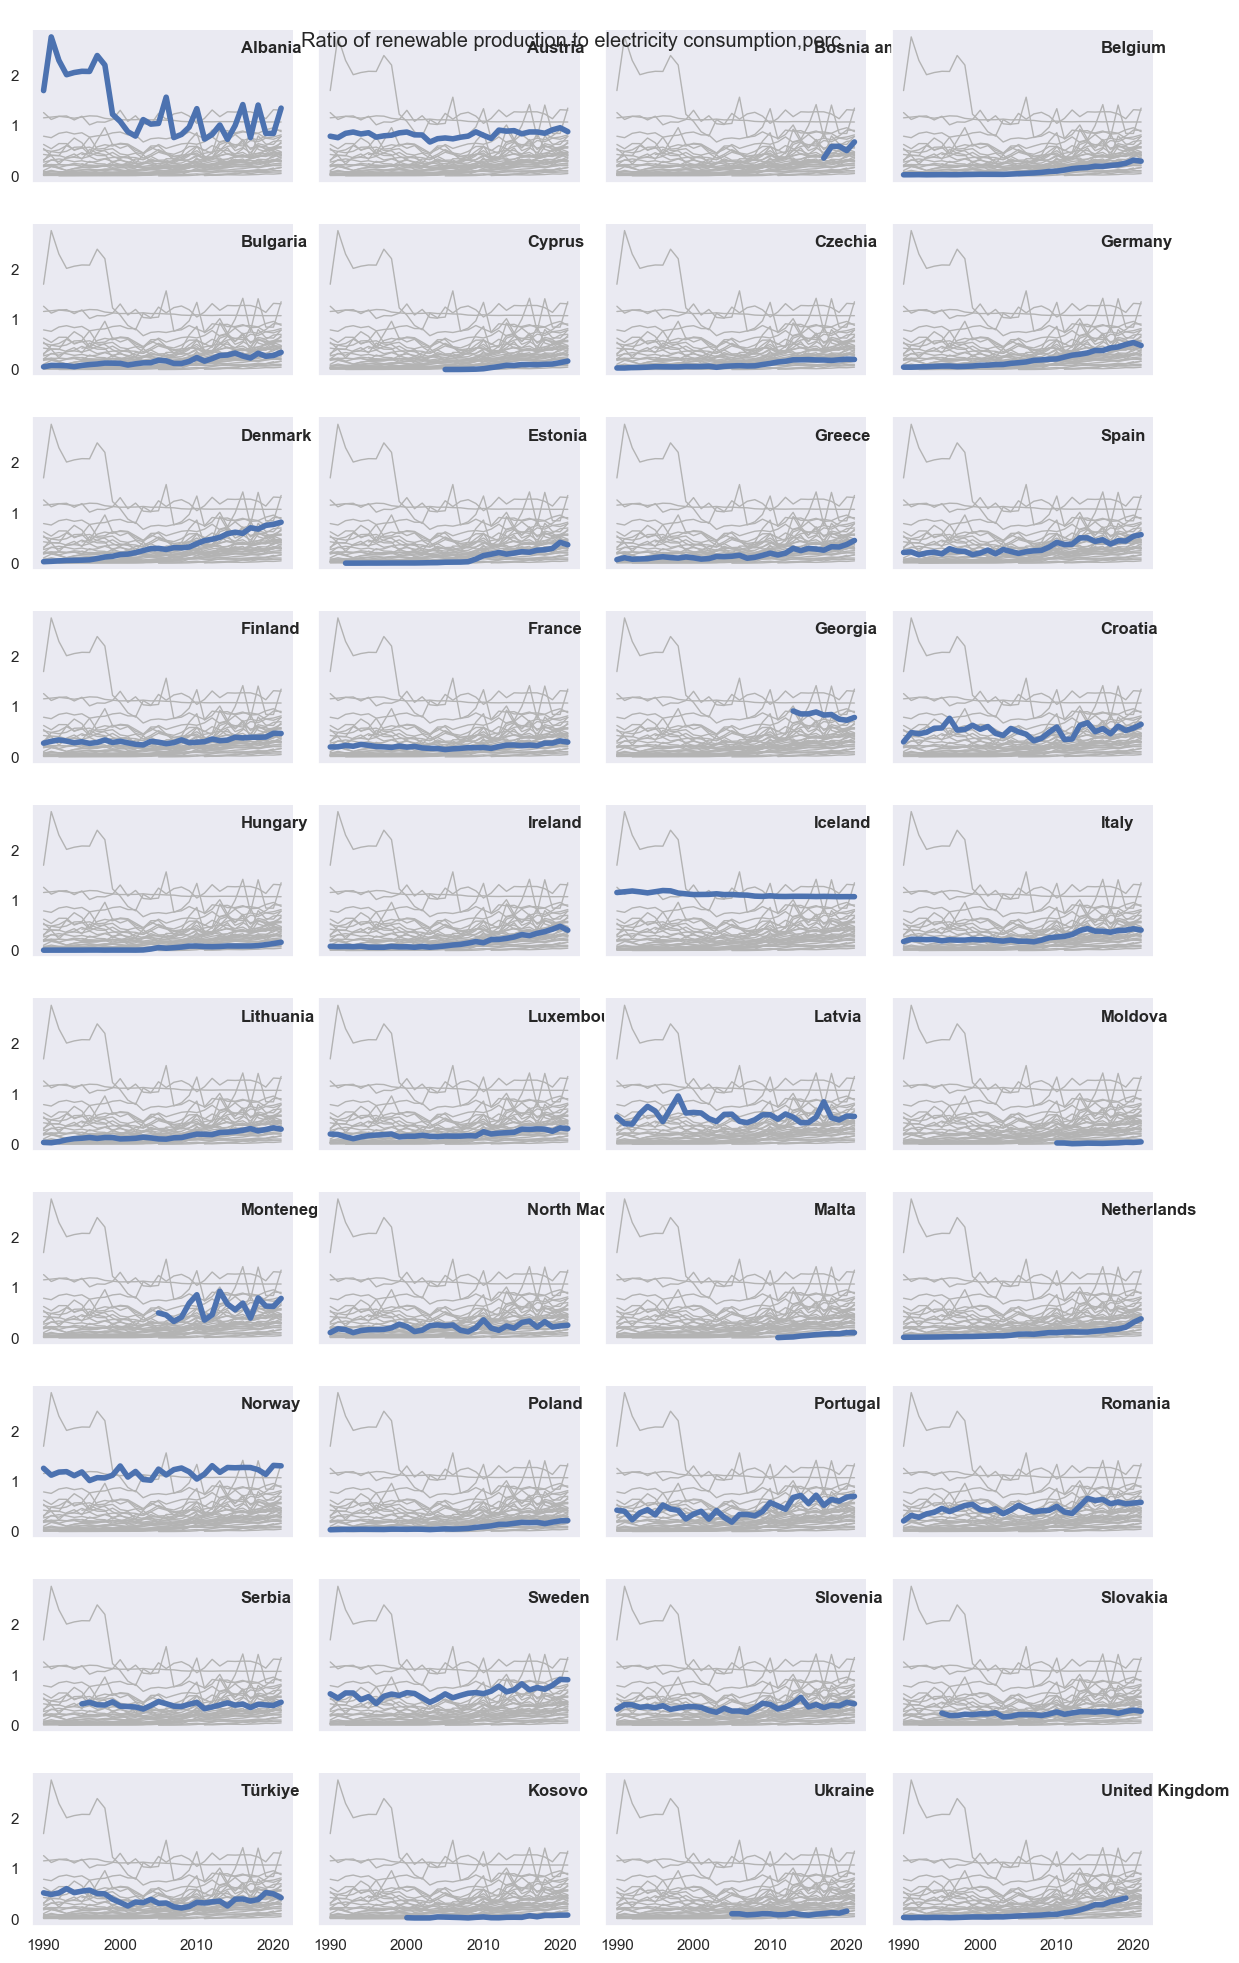

In [72]:
plot_measure(concated,'Ratio of renewable production to electricity consumption,perc')

In [60]:
# #Energy consamption per capita,Megawatt-hour
# plot_measure(m_balance,'per_capita')